In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
from PlittGiocomo_CA1Morph_2019 import morph_analyses
pp = morph_analyses.preprocessing
u = morph_analyses.utilities 
ssm = morph_analyses.SimulatedSimMats
ut = morph_analyses.UnityTransforms


from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
ut.inv_wallmorphx(.15)-ut.inv_wallmorphx(0)

4.113103177360944

In [2]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
df_mouse = df[df["MouseName"]=='4343706']
df_mouse

MouseName  DateFolder  SessionNumber              Track  RewardCount  \
3322   4343706  07_02_2020              2  TwoTower_foraging           77   
3355   4343706  09_02_2020              2  TwoTower_foraging           60   
3380   4343706  10_02_2020              3  TwoTower_foraging           55   
3390   4343706  11_02_2020              3  TwoTower_foraging           56   

      Imaging ImagingRegion   DateTime  \
3322        1           CA1 2020-02-07   
3355        1           CA1 2020-02-09   
3380        1           CA1 2020-02-10   
3390        1           CA1 2020-02-11   

                                              data file scanmat s2pfolder  
3322  D:\VR_Data\TwoTower\4343706\07_02_2020\TwoTowe...    None      None  
3355  D:\VR_Data\TwoTower\4343706\09_02_2020\TwoTowe...    None      None  
3380  D:\VR_Data\TwoTower\4343706\10_02_2020\TwoTowe...    None      None  
3390  D:\VR_Data\TwoTower\4343706\11_02_2020\TwoTowe...    None      None

In [4]:
# load sf regression info for priors
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [5]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.1,1.1,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*u.gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1,keepdims=True)
    return priors, prior, post
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg,sigma_likelihood=.4)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg,sigma_likelihood=.4)

# Figures for schematic of how model works

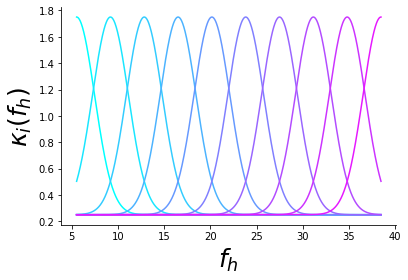

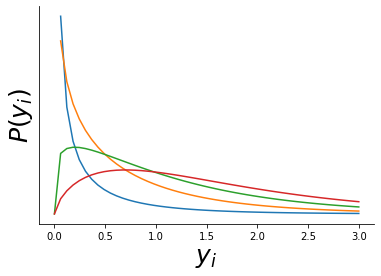

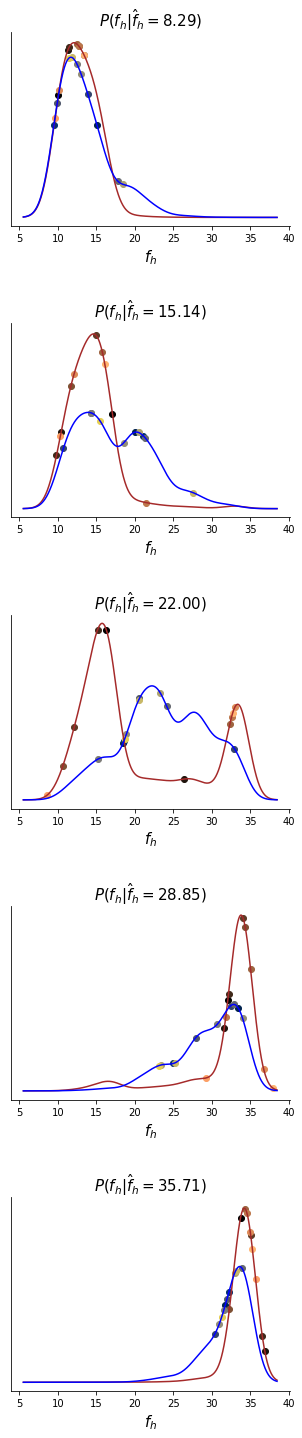

In [15]:
xx = np.linspace(-.1,1.1,num=rare_prior.size)


f,ax = plt.subplots()
mus = np.linspace(-.1,1.1,num = 10)
for i, mu in enumerate(mus.tolist()):
    ax.plot(ut.inv_wallmorphx(xx),1.5*u.gaussian(mu,.1,xx)+.25,color=plt.cm.cool(np.float(i)/10.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$f_h$",fontsize=25)
ax.set_ylabel("$\kappa_i(f_h)$",fontsize=25)

# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\tuning_curves.png",format='png')
# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\tuning_curves.pdf",format='pdf')

f,ax = plt.subplots()
_x = np.linspace(0,3)
for alpha in np.arange(.2,1.8,.5).tolist(): 
    ax.plot(_x,sp.stats.gamma.pdf(_x,alpha),label="k=%.1f" % alpha )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$y_i$",fontsize=25)
ax.set_ylabel("$P(y_i)$",fontsize=25)
ax.set_yticks([])

# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\gamma_kappa.png",format='png')
# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\gamma_kappa.pdf",format='pdf')

f,ax = plt.subplots(5,1,figsize=[5,25])
f.subplots_adjust(hspace=.5)
shats= np.array([0, .25,.5,.75,1])
rare_post, xx = ssm.calculate_posterior(rare_prior,shats)
freq_post, xx = ssm.calculate_posterior(freq_prior,shats)
for j,shat in enumerate(shats.tolist()):
    ax[j].plot(ut.inv_wallmorphx(xx),rare_post[j,:],color='brown')
    ax[j].plot(ut.inv_wallmorphx(xx),freq_post[j,:],color='blue')
    
    rare_post_spline = spline(xx,rare_post[j,:])
    freq_post_spline = spline(xx,freq_post[j,:])
    # sample 10 times
    rare_sampling_spline=ssm.make_sampling_spline(xx,rare_post[j,:])
    freq_sampling_spline=ssm.make_sampling_spline(xx,freq_post[j,:])
    eps = 5E-3
    for s in range(10):
        sample = rare_sampling_spline(np.random.rand(1))
        ax[j].scatter(ut.inv_wallmorphx(sample),rare_post_spline(sample), c= np.array(plt.cm.copper(s/10.))[np.newaxis,:])
        
        sample = freq_sampling_spline(np.random.rand(1))
        ax[j].scatter(ut.inv_wallmorphx(sample),freq_post_spline(sample), c= np.array(plt.cm.cividis(s/10.))[np.newaxis,:])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].set_title("$P(f_h|\hat{f}_h=%.2f)$" % ut.inv_wallmorphx(shat),fontsize=15)
    ax[j].set_xlabel("$f_h$",fontsize = 15)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\posterior_samples.png",format='png')


    
# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.pdf",format='pdf')
# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.png",format='png')

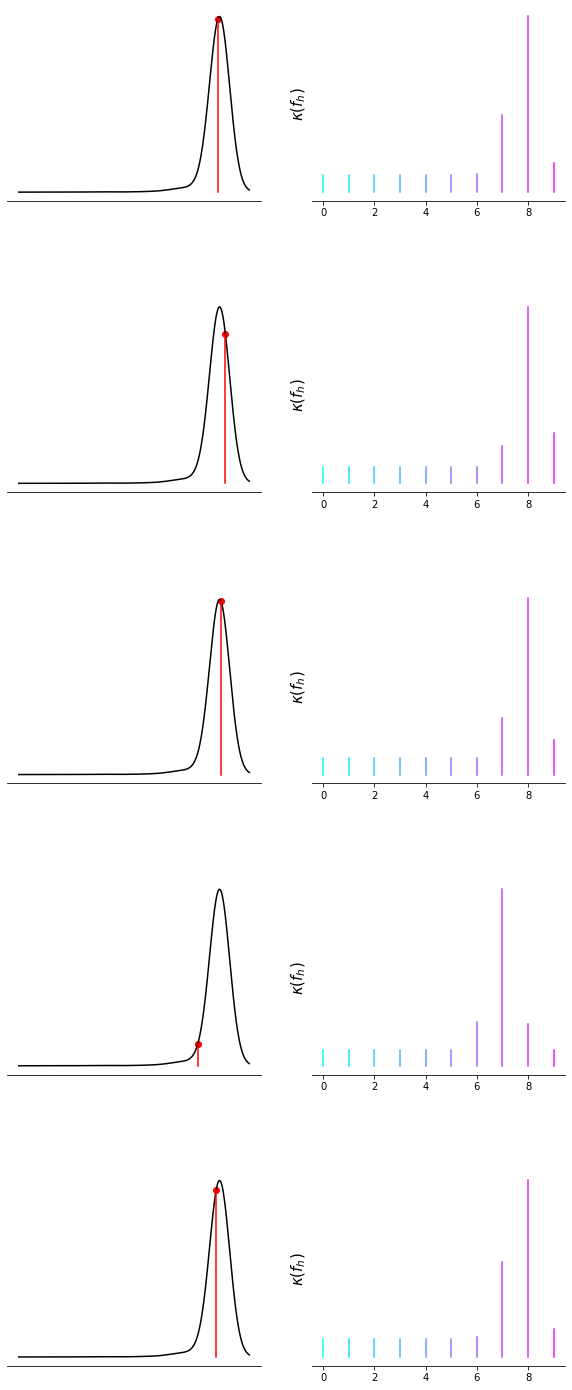

In [37]:
f,ax = plt.subplots(5,2,figsize=[10,25])
f.subplots_adjust(hspace=.5)

# sample 10 times
eps = 5E-3
for s in range(5):
    ax[s,0].plot(ut.inv_wallmorphx(xx),rare_post[-1,:],color='black')
    sample = rare_sampling_spline(np.random.rand(1))
    ax[s,0].scatter(ut.inv_wallmorphx(sample),rare_post_spline(sample), c= 'red')
    ax[s,0].plot(ut.inv_wallmorphx(sample)*np.array([1, 1]),[0, rare_post_spline(sample)],color='red')
        
    
    ax[s,0].set_yticks([])
    ax[s,0].spines['top'].set_visible(False)
    ax[s,0].spines['right'].set_visible(False)
#     ax[s].set_title("$P(f_h|\hat{f}_h=%.2f)$" % ut.inv_wallmorphx(shat),fontsize=15)
#     ax[s].set_xlabel("$f_h$",fontsize = 15)
    ax[s,0].set_xticks([])
    ax[s,0].spines['left'].set_visible(False)
    
    
    
    mus = np.linspace(-.1,1.1,num = 10)
    for i, mu in enumerate(mus.tolist()):
        ax[s,1].plot([i, i],[-.1, u.gaussian(mu,.1,sample)],color=plt.cm.cool(np.float(i)/10.))
    ax[s,1].spines['top'].set_visible(False)
    ax[s,1].spines['right'].set_visible(False)
    ax[s,1].spines['left'].set_visible(False)
    ax[s,1].set_yticks([])
    ax[s,1].set_ylabel("$\kappa(f_h)$",fontsize=15)

    
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\example_samples.pdf",format='pdf')

In [ ]:
f,ax = plt.subplots()
mus = np.linspace(-.1,1.1,num = 10)
for i, mu in enumerate(mus.tolist()):
    ax.plot(ut.inv_wallmorphx(xx),1.5*u.gaussian(mu,.1,xx)+.25,color=plt.cm.cool(np.float(i)/10.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$f_h$",fontsize=25)
ax.set_ylabel("$\kappa_i(f_h)$",fontsize=25)

In [38]:
def single_session_kldiv(_wm,yhat):
    kl_divs=[]
    _x = x.ravel()
    _xmask = (_x>=-.1) & (_x<=1.1)
    HH = 0


    for perm in range(yhat.shape[0]):
        _yh = yhat[perm,:]
        wmsm = u.gaussian(_wm[:,np.newaxis,np.newaxis],.1,_x[np.newaxis,:,np.newaxis])
        yhsm = u.gaussian(_yh[:,np.newaxis,np.newaxis],.1,_x[np.newaxis,np.newaxis,:])
        H = np.sum(wmsm*yhsm,axis=0)
        Z=H.sum(axis=1)
        H/=H.sum(axis=1,keepdims=True)

        rare_kl,freq_kl = [],[]
#         print(rare_post.shape,H.shape)
        for row in range(H.shape[1]):
            if (_x[row]>=.1) and (_x[row]<=1.1):
#                 print(rare_post.shape,H.shape)
                rare_kl.append(sp.stats.entropy(rare_post[row,:],H[row,:],base=2))
                freq_kl.append(sp.stats.entropy(freq_post[row,:],H[row,:],base=2))
        rare_kl,freq_kl = np.array(rare_kl),np.array(freq_kl)
        kl_divs.append([rare_kl.mean(),freq_kl.mean()])


        HH+=H
        
    HH/=HH.sum(axis=1,keepdims=True)
    f,ax = plt.subplots()
    ax.imshow(HH.T,cmap='RdPu',extent=[ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.3),ut.inv_wallmorphx(-.3)])
    
    rare_kl,freq_kl = [],[]
    for row in range(HH.shape[1]):
        if (_x[row]>=.1) and (_x[row]<=1.1):
            rare_kl.append(sp.stats.entropy(rare_post[row,:],HH[row,:],base=2))
            freq_kl.append(sp.stats.entropy(freq_post[row,:],HH[row,:],base=2))
    rare_kl,freq_kl = np.array(rare_kl),np.array(freq_kl)
    
    ax.set_title("diff KL %f" % (np.array(rare_kl).mean()-np.array(freq_kl).mean()))
    
  
    
    return kl_divs,f


# Confirming that this model reproduces the posterior and superficially has the statistics of the real neural data

In [39]:
x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
morphs = np.linspace(-.1,1.1,num=100)
# ssm.simmat_distribution(_x,rare_prior,nperms=100,n_neurons=1000,rbf_sigma=.4,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])
# rare_simdat_wide,rare_sm, rare_sf_wide = ssm.simmat_distribution(ut.wallmorphx(morphs),rare_prior,n_neurons=1000,nperms=100,rbf_sigma=.1,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])
# freq_simdat_wide,freq_sm, freq_sf_wide = ssm.simmat_distribution(ut.wallmorphx(morphs),freq_prior,n_neurons=1000,nperms=100,rbf_sigma=.1,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])

rare_simdat_wide,rare_sm, rare_sf_wide = ssm.simmat_distribution(ut.wallmorphx(morphs),rare_prior,n_neurons=500,nperms=100,rbf_sigma=.15,alpha=2,beta=0.,xx_lims=[-.3,1.3],n_samps=3)
freq_simdat_wide,freq_sm, freq_sf_wide = ssm.simmat_distribution(ut.wallmorphx(morphs),freq_prior,n_neurons=500,nperms=100,rbf_sigma=.15,alpha=2,beta=0.,xx_lims=[-.3,1.3],n_samps=3)

0
0


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


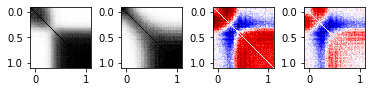

In [40]:
mu_rare_sm,mu_freq_sm = np.nanmean(rare_sm,axis=0),np.nanmean(freq_sm,axis=0)
f,ax = plt.subplots(1,4)
f.subplots_adjust(wspace=.5)
ax[0].imshow(mu_rare_sm,cmap='Greys',vmin = np.percentile(mu_rare_sm.ravel(),10),vmax = np.percentile(mu_rare_sm.ravel(),90),extent=[-.1,1.1,1.1,-.1])
ax[1].imshow(mu_freq_sm,cmap='Greys',vmin = np.percentile(mu_freq_sm.ravel(),10),vmax = np.percentile(mu_freq_sm.ravel(),90),extent=[-.1,1.1,1.1,-.1])


mu_rare_norm, mu_freq_norm = np.zeros(rare_sm.shape),np.zeros(freq_sm.shape)
mu_rare_bin, mu_freq_bin = np.zeros(rare_sm.shape),np.zeros(freq_sm.shape)
for i in range(mu_rare_sm.shape[0]):
    
    _rare = np.copy(rare_sm[i,:,:])
    _rare[np.diag_indices_from(_rare)]=np.nan
    mu_rare_bin[i,:,:] = np.copy(_rare)
    mu_rare_norm[i,:,:]=(_rare - np.nanmean(_rare.ravel()))/np.nanstd(_rare.ravel())
    
    _freq = np.copy(freq_sm[i,:,:])
    _freq[np.diag_indices_from(_freq)]=np.nan
    mu_freq_norm[i,:,:]=(_freq - np.nanmean(_freq.ravel()))/np.nanstd(_freq.ravel())
    mu_freq_bin[i,:,: ]=np.copy(_freq)
mu_rare_norm,mu_freq_norm = np.nanmean(mu_rare_norm,axis=0),np.nanmean(mu_freq_norm,axis=0)
mu_rare_bin,mu_freq_bin = np.nanmean(mu_rare_bin,axis=0),np.nanmean(mu_freq_bin,axis=0)    
ax[2].imshow(mu_rare_sm-mu_freq_sm,cmap='seismic',vmin=-.05,vmax=.05,extent=[-.1,1.1,1.1,-.1])
ax[3].imshow(mu_rare_norm-mu_freq_norm,cmap='seismic',vmin=-1,vmax=1,extent=[-.1,1.1,1.1,-.1])
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\avgsimmats.pdf" , format="pdf")
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\avgsimmats.png" , format="png")

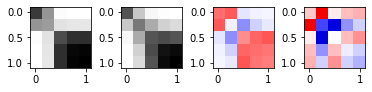

In [42]:
edges = [[-.1,.1,],[.15,.35],[.4,.6],[.65,.85],[.9,1.1]]
rbinmu = np.zeros([5,5])
fbinmu = np.zeros([5,5])
normdiffbin=np.zeros([5,5])
for i,ipair in enumerate(edges):
    imask = (morphs>=ipair[0])&(morphs<=ipair[1])
#     print(imask.shape)
    for j,jpair in enumerate(edges):
        jmask = (morphs>=jpair[0])&(morphs<=jpair[1])
#         print(jmask.shape)
        rbinmu[i,j]=np.nanmean(mu_rare_bin[imask[:,np.newaxis]*jmask[np.newaxis,:]])
        fbinmu[i,j]=np.nanmean(mu_freq_bin[imask[:,np.newaxis]*jmask[np.newaxis,:]])
#         normdiffbin[i,j]=normdiff[imask[:,np.newaxis]*jmask[np.newaxis,:]].mean()
f,ax = plt.subplots(1,4)
f.subplots_adjust(wspace=.5)
ax[0].imshow(rbinmu,cmap='Greys',extent=[-.1,1.1,1.1,-.1])
ax[1].imshow(fbinmu,cmap='Greys',extent=[-.1,1.1,1.1,-.1])
ax[2].imshow(rbinmu-fbinmu,cmap='seismic',vmin=-.1,vmax=.1,extent=[-.1,1.1,1.1,-.1])
ax[3].imshow(sp.stats.zscore(rbinmu,axis=None)-sp.stats.zscore(fbinmu,axis=None),cmap='seismic',vmin=-1.,vmax=1.,extent=[-.1,1.1,1.1,-.1])
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\avgsimmats_bin.pdf" , format="pdf")
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\avgsimmats_bin.png" , format="png")

(100, 100, 100)


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

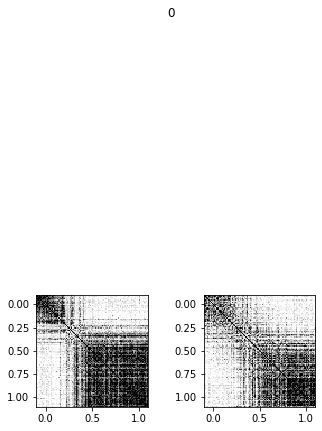

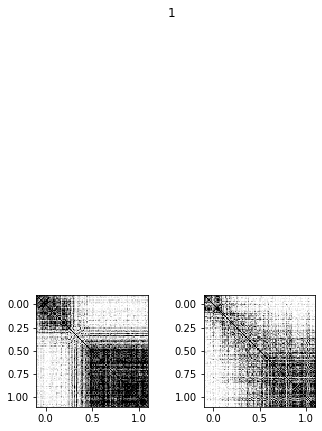

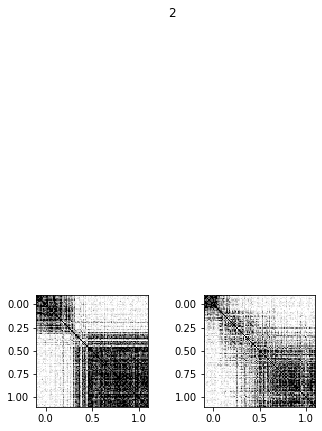

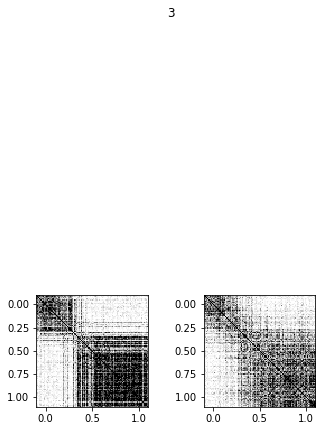

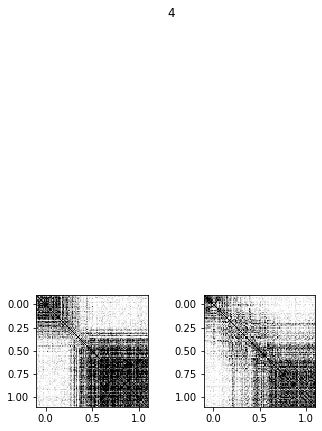

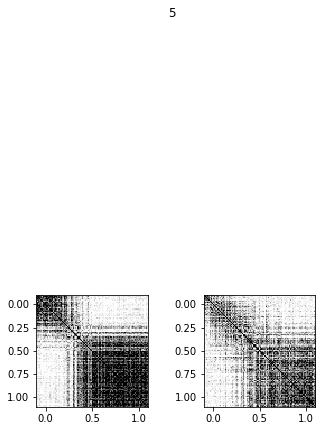

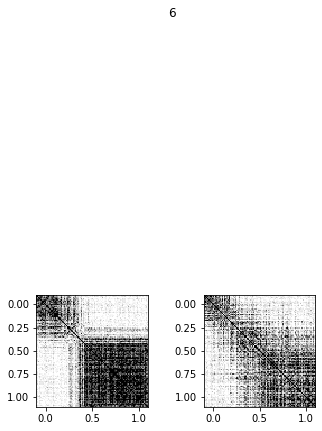

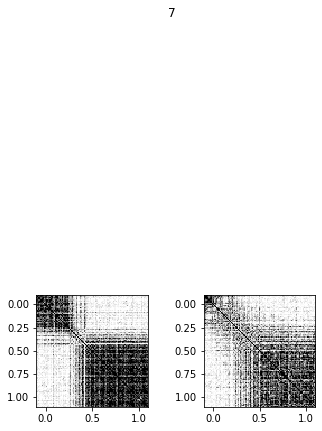

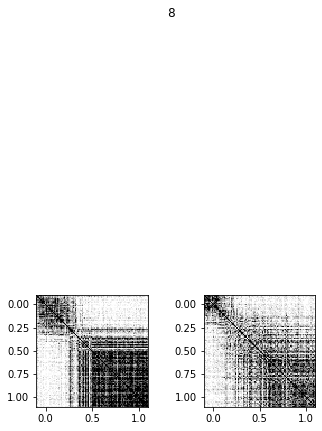

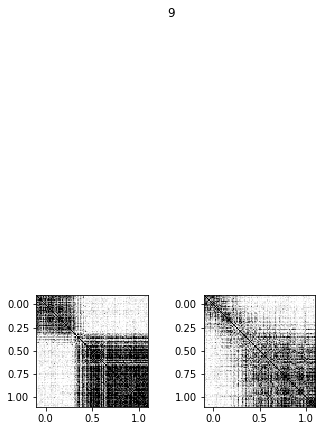

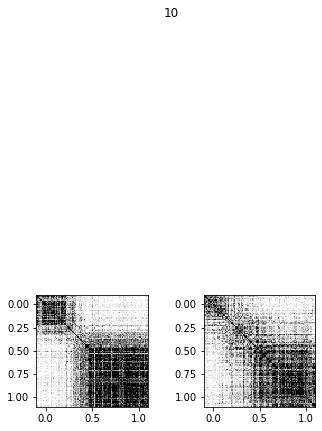

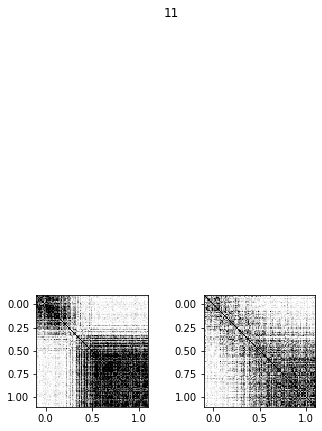

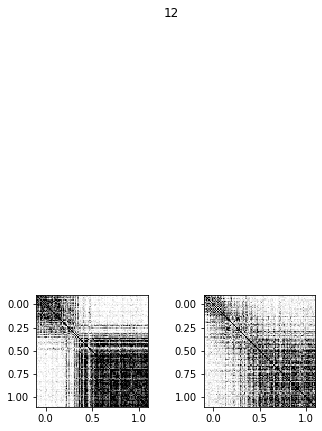

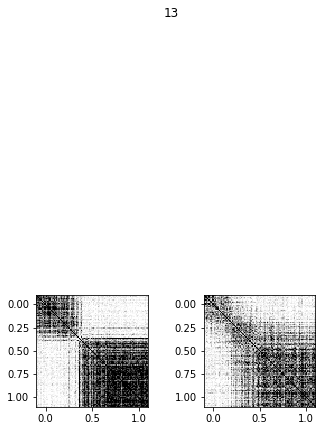

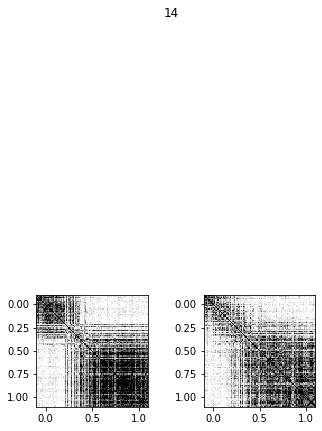

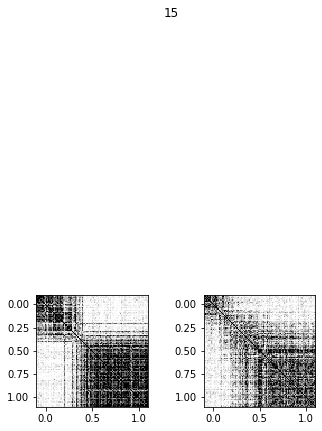

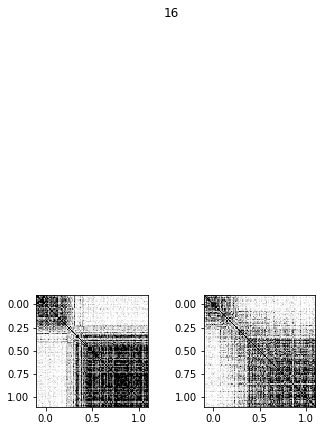

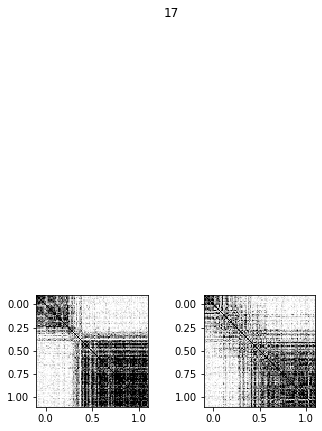

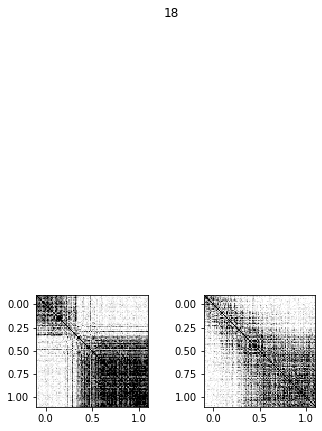

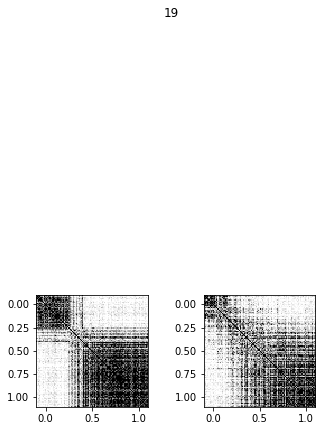

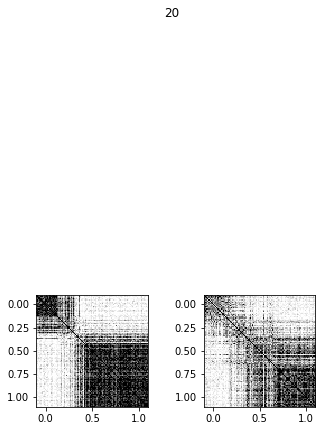

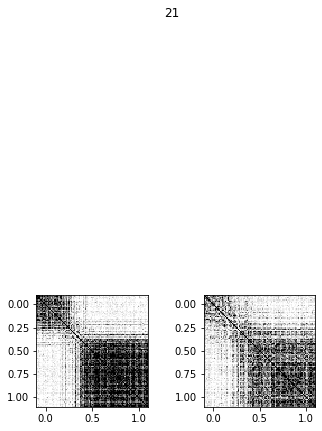

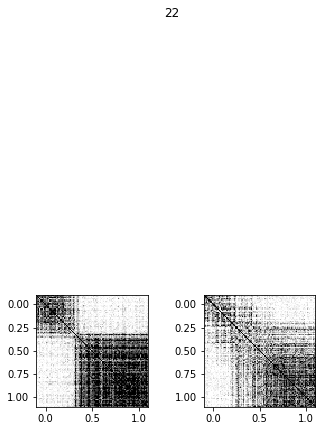

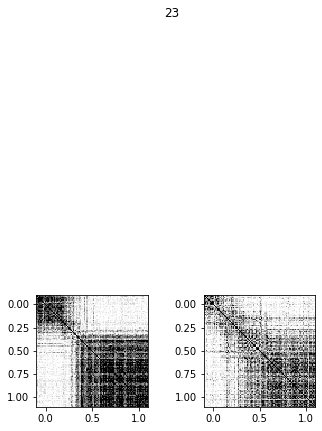

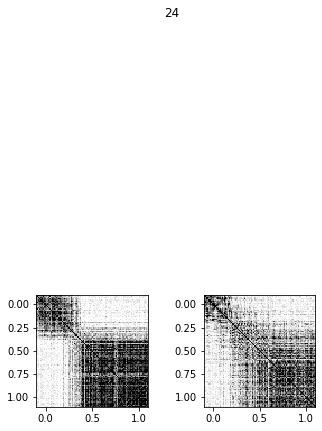

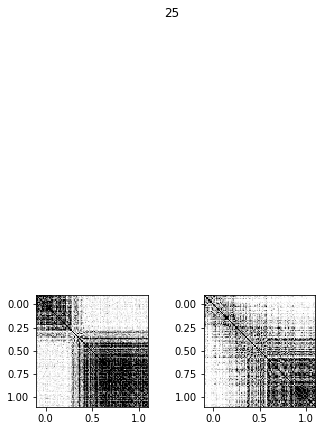

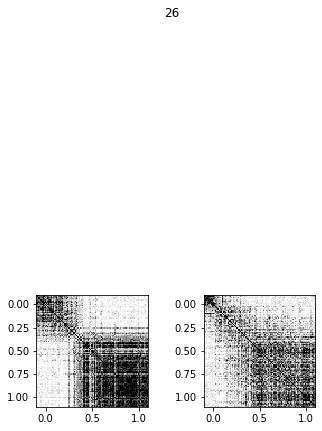

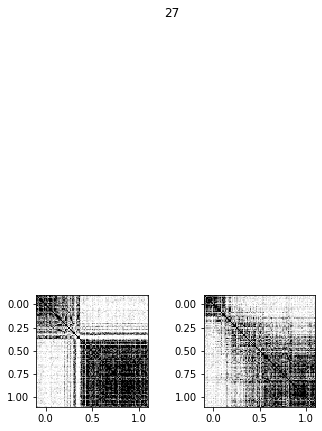

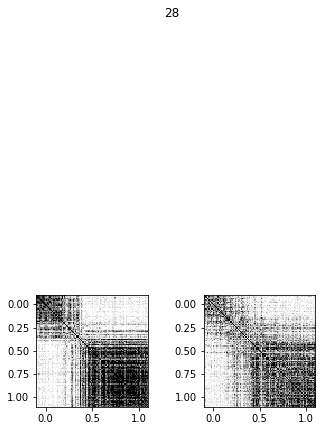

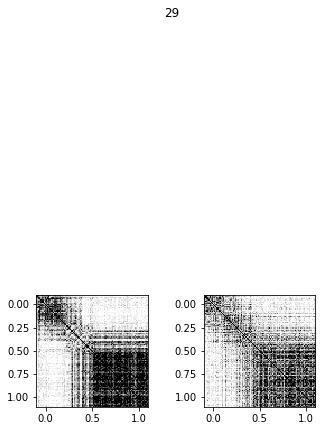

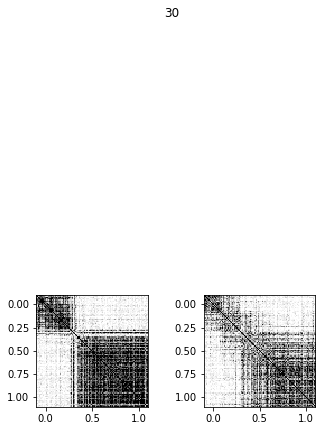

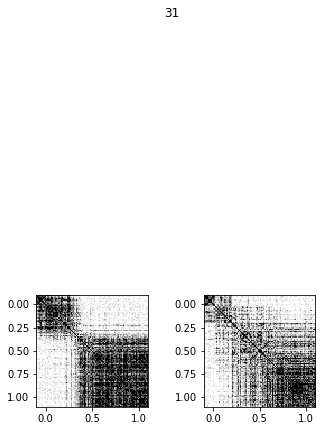

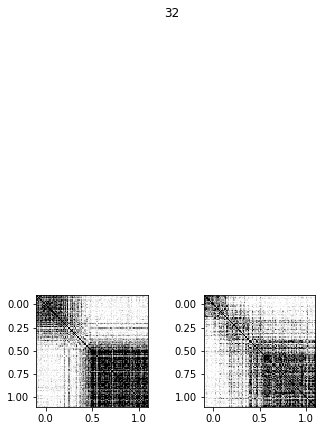

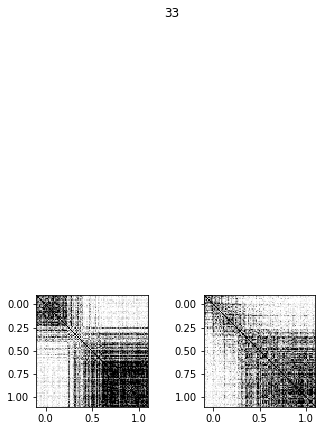

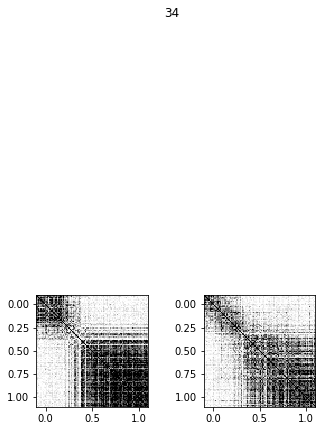

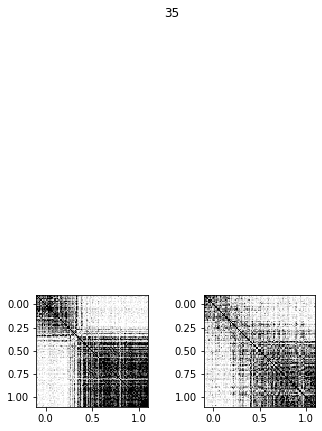

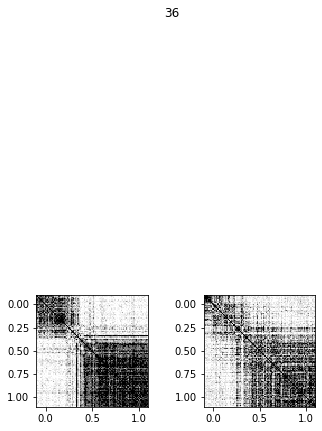

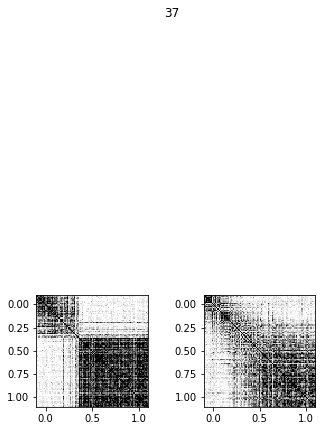

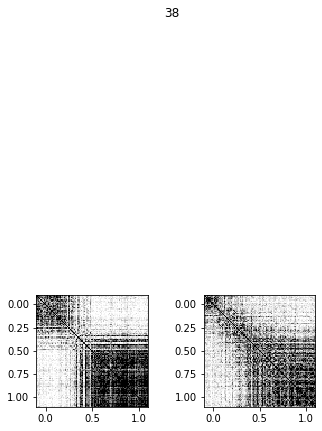

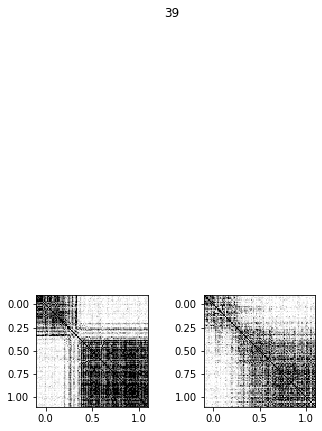

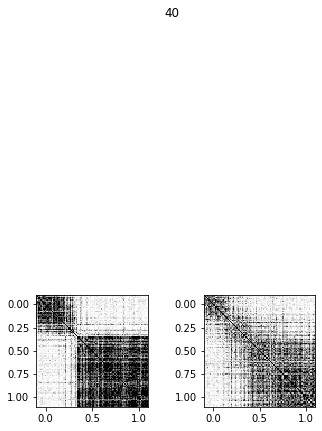

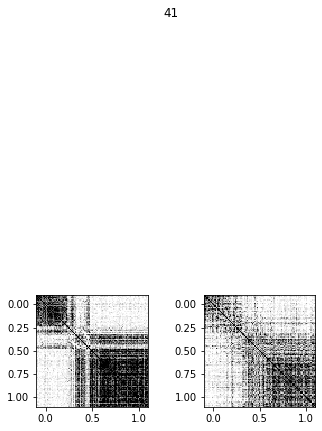

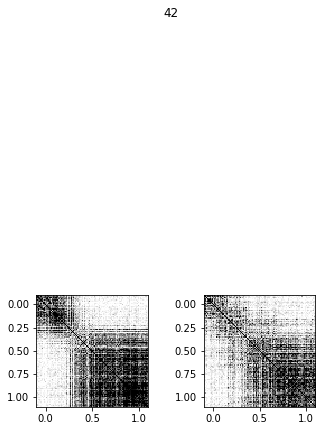

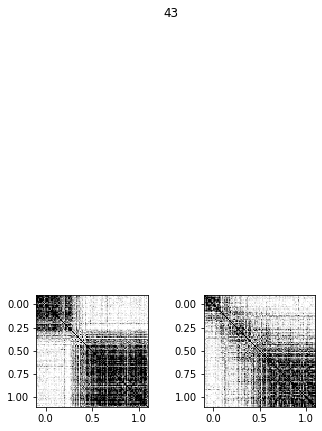

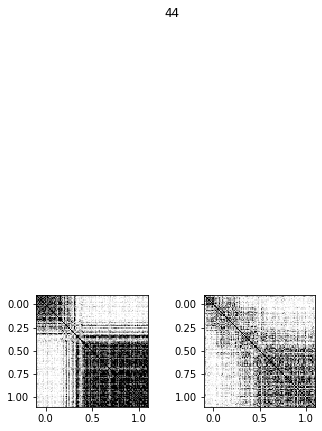

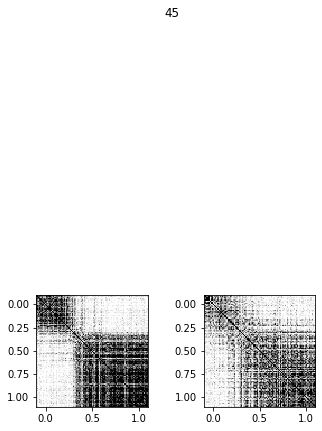

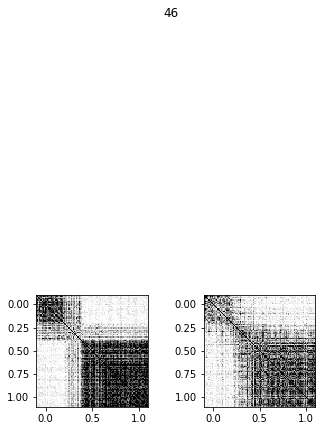

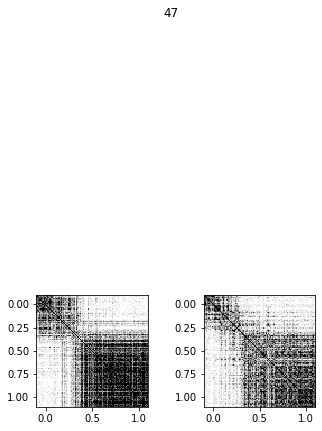

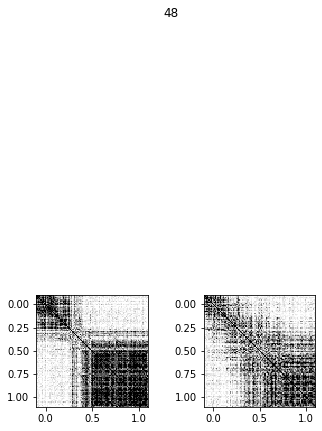

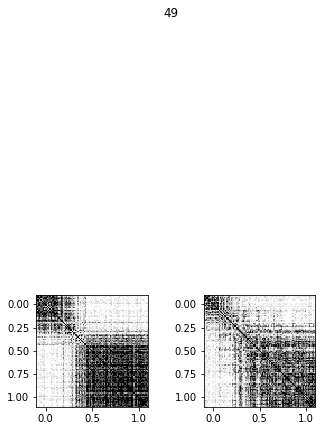

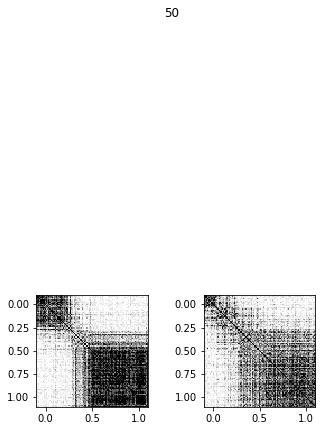

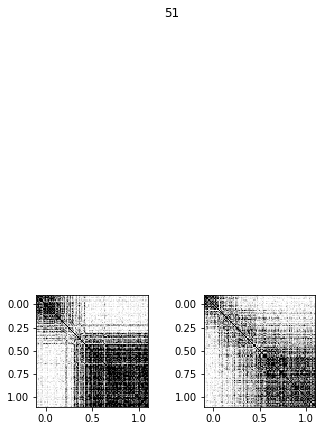

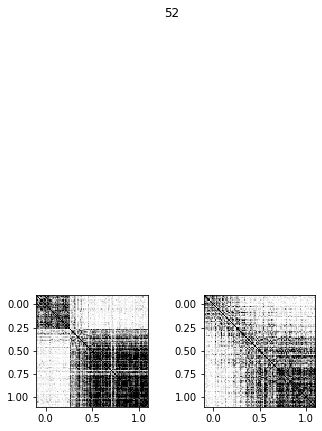

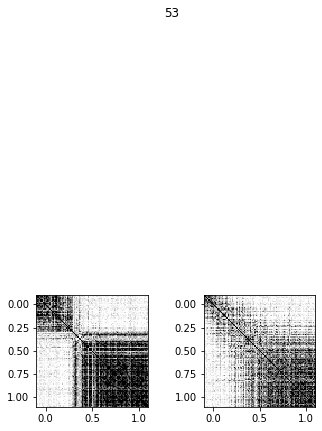

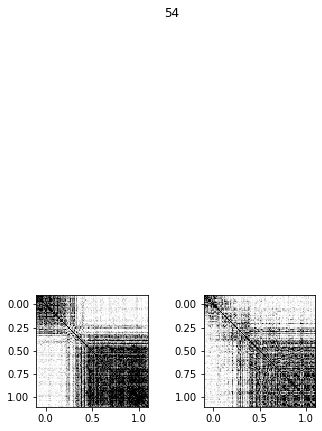

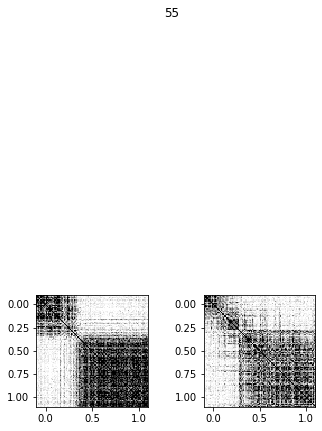

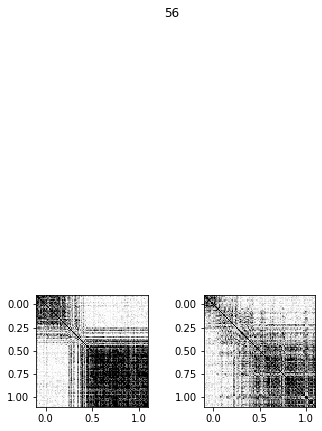

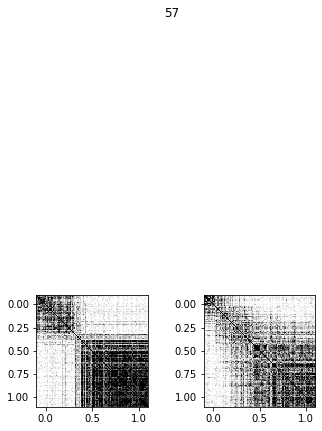

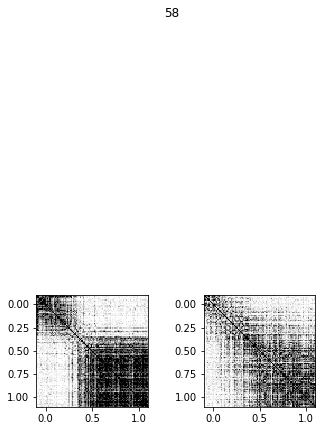

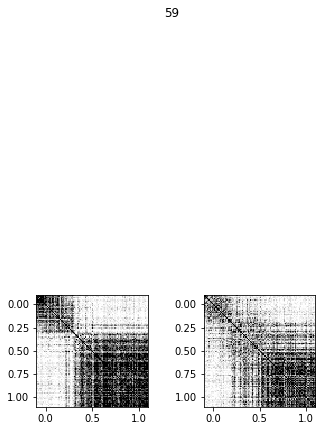

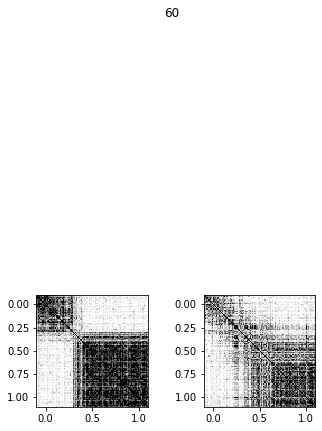

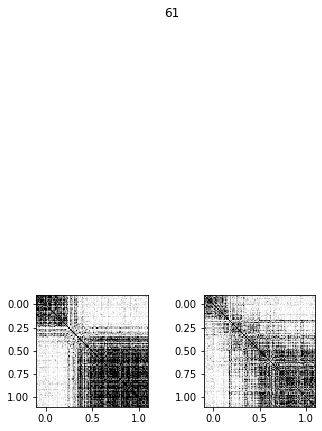

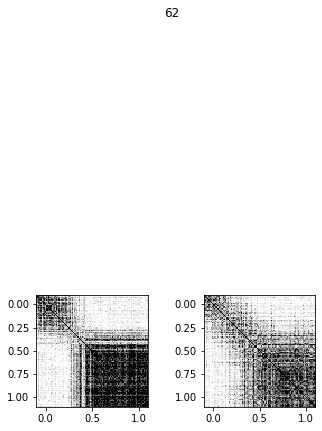

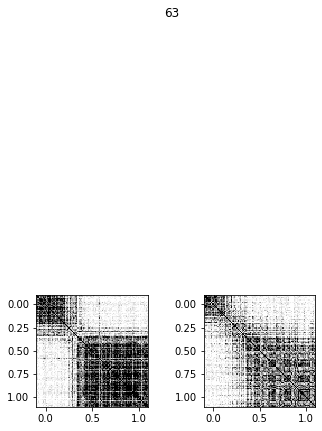

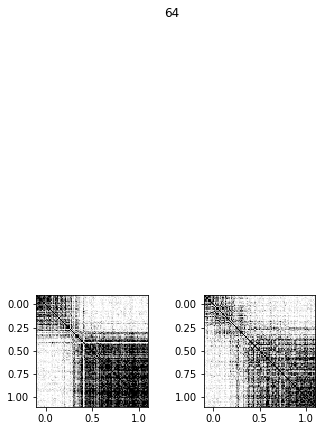

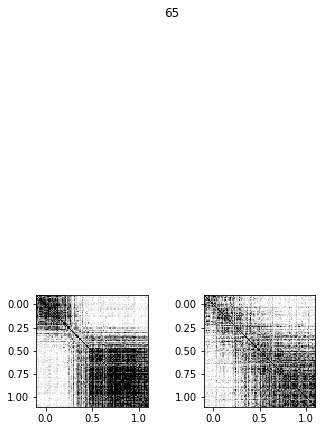

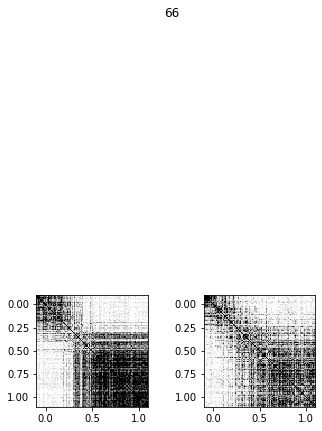

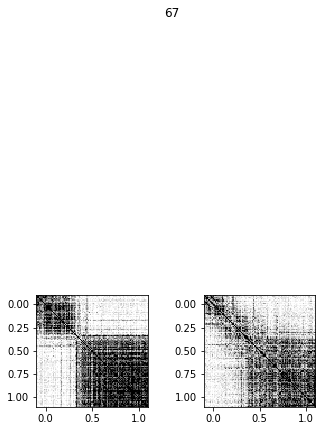

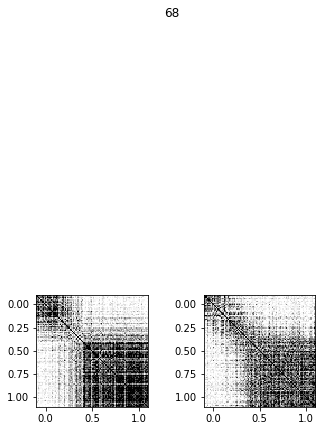

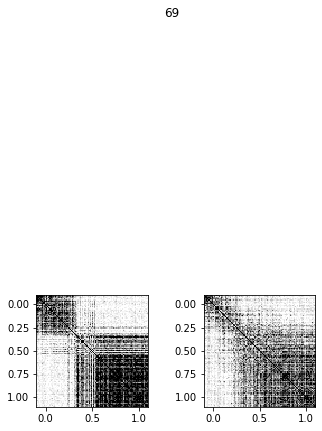

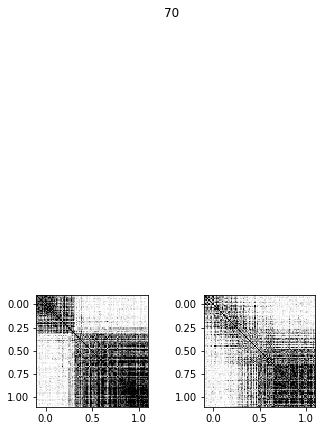

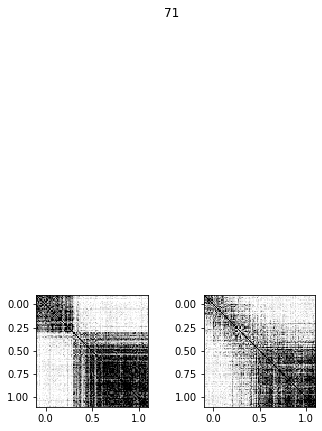

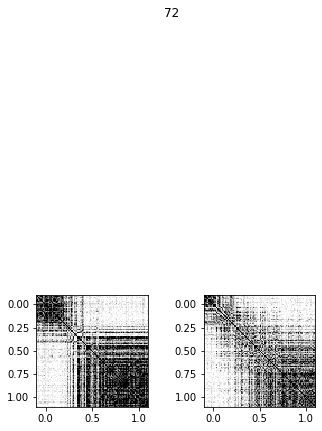

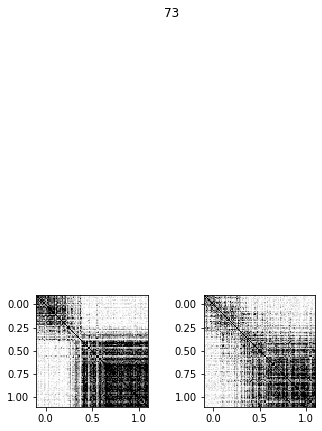

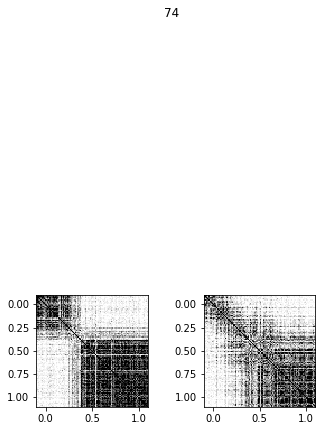

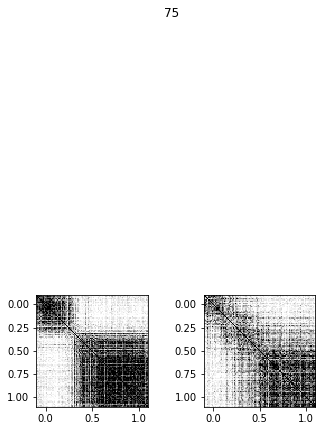

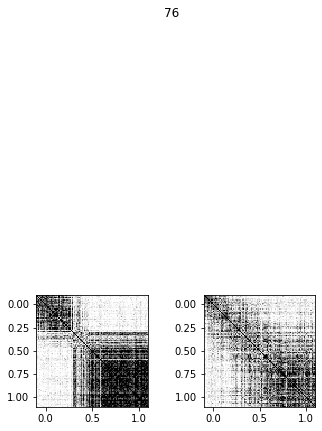

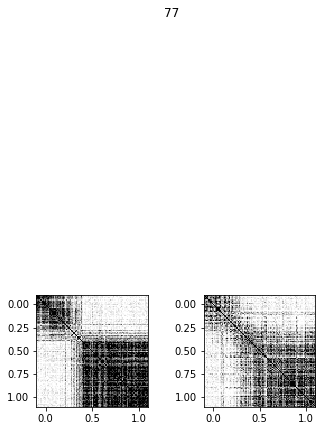

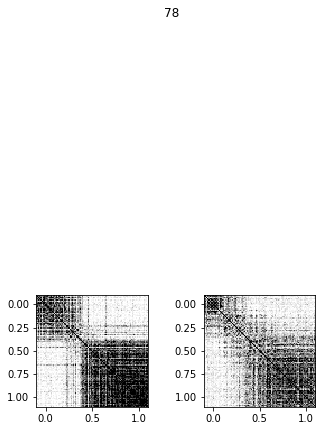

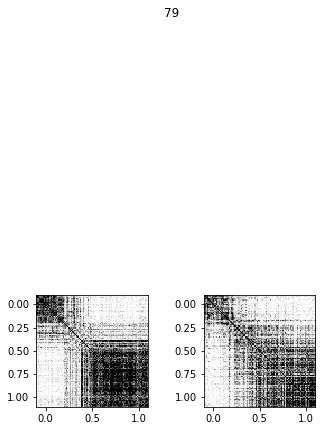

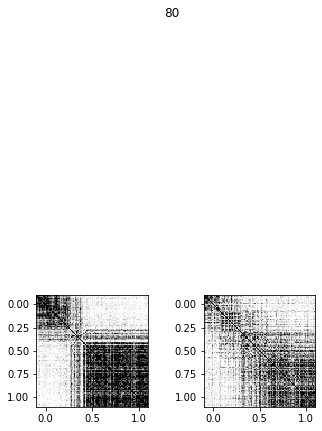

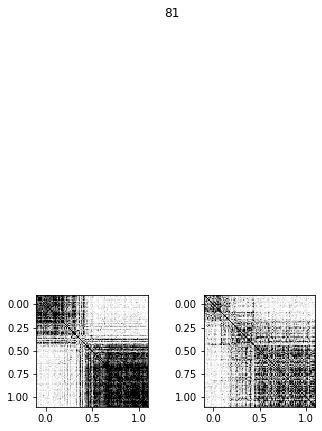

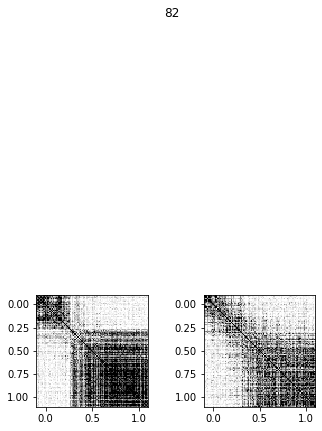

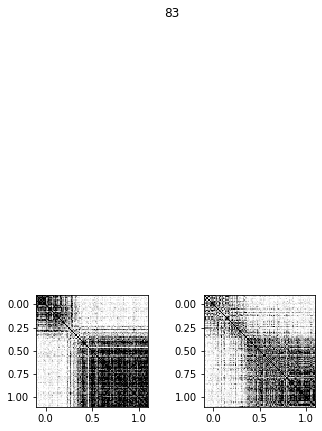

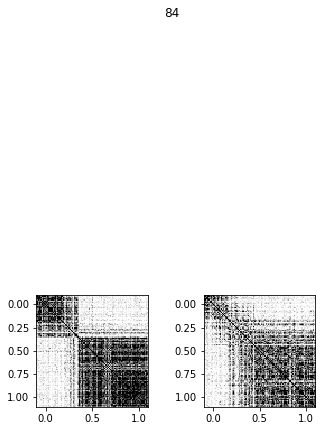

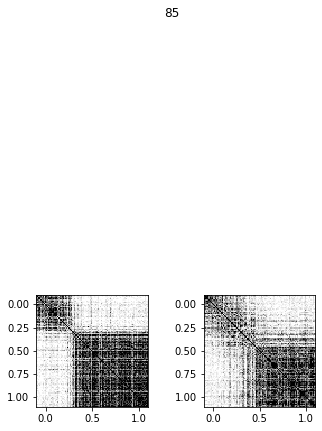

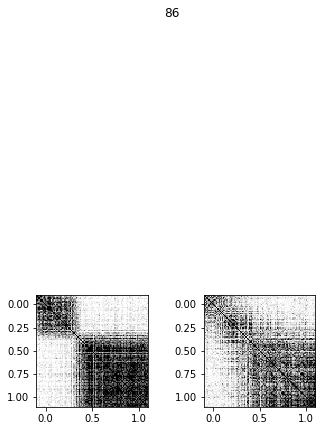

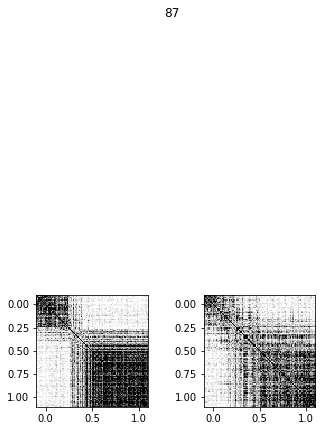

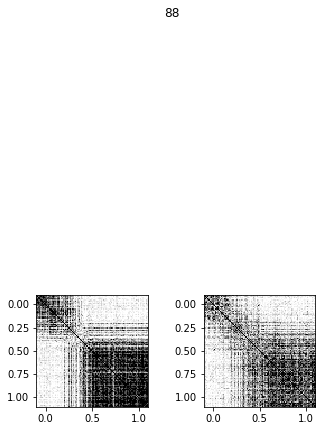

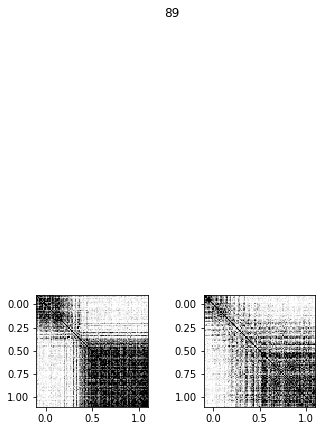

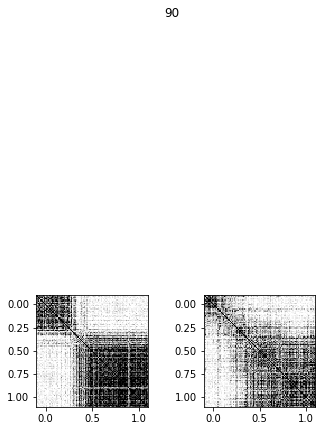

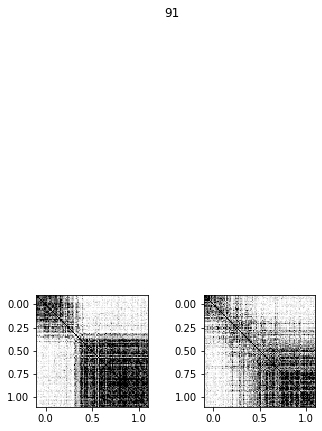

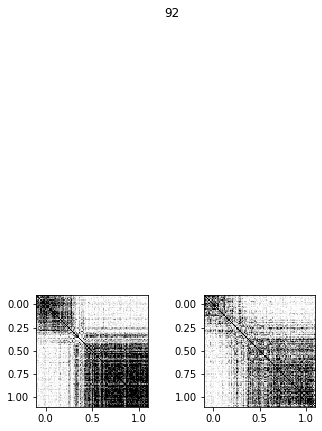

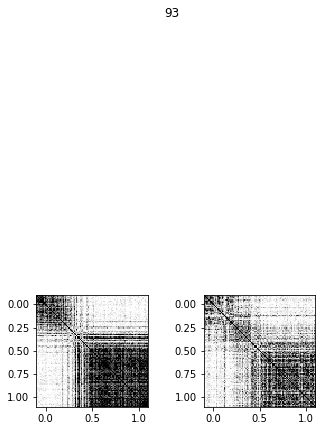

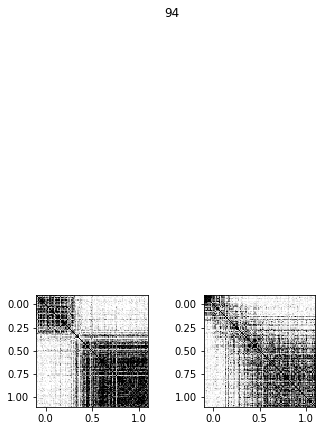

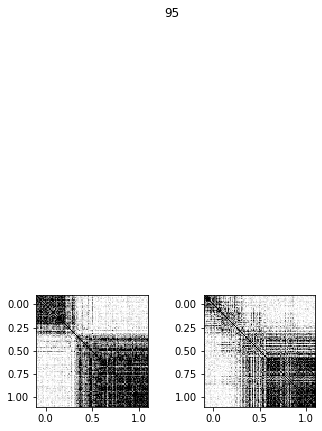

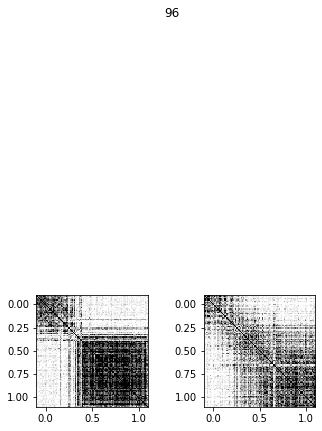

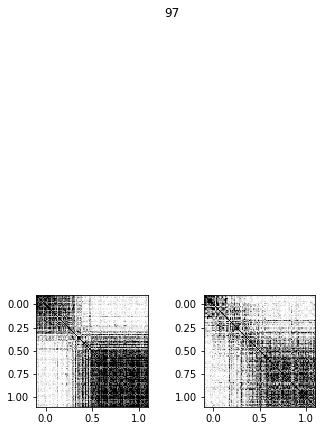

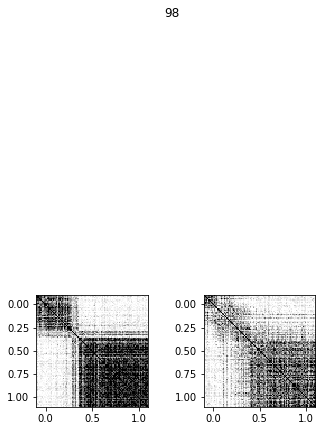

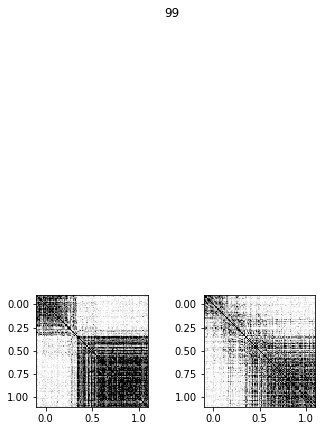

In [45]:
print(rare_sm.shape)
for i in range(rare_sm.shape[0]):
    f,ax = plt.subplots(1,2,figsize=[5,10])
    f.subplots_adjust(wspace=.5)
    ax[0].imshow(rare_sm[i,:,:],cmap='Greys',vmin=np.percentile(rare_sm[i,:,:].ravel(),10),vmax=np.percentile(rare_sm[i,:,:].ravel(),90),extent=[-.1,1.1,1.1,-.1])
    ax[1].imshow(freq_sm[i,:,:],cmap='Greys',vmin=np.percentile(rare_sm[i,:,:].ravel(),10),vmax=np.percentile(rare_sm[i,:,:].ravel(),90),extent=[-.1,1.1,1.1,-.1])
    f.suptitle("%d" % i)
    f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\KLDivSess\\KLDivSess_%d.pdf" % i, format="pdf")

In [26]:
mask0 = (morphs>=-.1) & (morphs<=.1)
mask1 = (morphs>=.9) & (morphs<=1.1)
centroid0,centroid1 = np.median(rare_sf_wide[:,mask0],axis=1,keepdims=True),np.median(rare_sf_wide[:,mask1],axis=1,keepdims=True)
rare_yhat = (rare_sf_wide- centroid0)/(centroid1-centroid0)*(1.073-.094) +.094 #(38.051-10.537) + 10.537 #
rare_yhat = np.clip(rare_yhat,-.3,1.3)

centroid0,centroid1 = np.median(freq_sf_wide[:,mask0],axis=1,keepdims=True),np.median(freq_sf_wide[:,mask1],axis=1,keepdims=True)
freq_yhat = (freq_sf_wide- centroid0)/(centroid1-centroid0)*(1.073-.094) +.094 #(38.051-10.537) + 10.537 #
freq_yhat = np.clip(freq_yhat,-.3,1.3)
# print(rare_yhat.shape)

# f,ax = plt.subplots()
# ax.scatter(ut.wallmorphx(morphs),rare_sf_wide[0,:])
print(morphs.shape,rare_yhat.shape)
rare_kldivs,f=single_session_kldiv(ut.wallmorphx(morphs),rare_yhat)
#f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_avg_kldiv.pdf",format='pdf')
# print(np.array(kldivs).shape)

freq_kldivs,f=single_session_kldiv(ut.wallmorphx(morphs),freq_yhat)
# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_avg_kldiv.pdf",format='pdf')

(100,) (100, 100)


IndexError: index 250 is out of bounds for axis 0 with size 5

(100, 2)


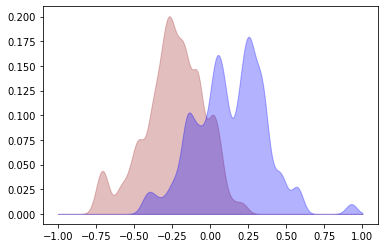

In [71]:
print(np.array(rare_kldivs).shape)
freq_kldivs,rare_kldivs = np.array(freq_kldivs),np.array(rare_kldivs)
rare_kldivs=rare_kldivs[:,0]-rare_kldivs[:,1]
freq_kldivs=freq_kldivs[:,0]-freq_kldivs[:,1]

f,ax = plt.subplots()
kk = np.linspace(-1.,1,num=1000)[np.newaxis,:]
rare_kldivs_sm = u.gaussian(rare_kldivs[:,np.newaxis],.05,kk).mean(axis=0)
freq_kldivs_sm = u.gaussian(freq_kldivs[:,np.newaxis],.05,kk).mean(axis=0)
ax.fill_between(kk.ravel(),rare_kldivs_sm,color='brown',alpha=.3)
ax.fill_between(kk.ravel(),freq_kldivs_sm,color='blue',alpha=.3)

# f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\kldiv_hist.pdf",format='pdf')
# ax.hist(freq_kldivs[:,0]-freq_kldivs[:,1])
# ax.hist(rare_kldivs[:,0]-rare_kldivs[:,1])

In [51]:
# confirm that this gives back a representation of the posterior
_x = np.linspace(-.1,1.1,num=100)
linmorphs = ut.wallmorphx(_x)
rare_post,xx,Z = ssm.calculate_posterior(rare_prior,_x,xx_lims = (-.1,1.1),calcZ=True)

morphs = np.linspace(-.1,1.1,num=100)
rare_simdat,rare_sm, rare_sf = ssm.simmat_distribution(_x,rare_prior,nperms=100,n_neurons=1000,rbf_sigma=.1,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])
print(rare_prior.shape)
rare_simdat_wide,rare_sm, rare_sf_wide = ssm.simmat_distribution(_x,rare_prior,nperms=100,n_neurons=1000,rbf_sigma=.4,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])

print(rare_sf_wide.shape) # simulations, trials



0
(1, 1000)
0
(100, 100)


In [52]:

Zspline = spline(_x,Z)
print(rare_simdat.shape)
map_estimate = xx[np.argmax(rare_post,axis=1)]
rare_prior_spline  = spline(xx,rare_prior)
for p in range(100):
    linmodel = hreg().fit(rare_sf[p:p+1,:].T,map_estimate)
#     mask0 = (morphs>=-.1) & (morphs<=.1)
#     mask1 = (morphs>=.9) & (morphs<=1.1)
#     centroid0,centroid1 = np.median(rare_sf[:,mask0],axis=1,keepdims=True),np.median(rare_sf[:,mask1],axis=1,keepdims=True)
#     rare_yhat = (rare_sf- centroid0)/(centroid1-centroid0)*(1.073-.094) +.094 #(38.051-10.537) + 10.537 #
#     rare_yhat = np.clip(rare_yhat,-.3,1.3)
    rare_sf[p,:] = linmodel.predict(rare_sf[p:p+1,:].T)
#     rare_sf = rare_yhat

#     centroid0,centroid1 = np.median(rare_sf_wide[:,mask0],axis=1,keepdims=True),np.median(rare_sf_wide[:,mask1],axis=1,keepdims=True)
#     rare_yhat = (rare_sf_wide- centroid0)/(centroid1-centroid0)*(1.073-.094) +.094 #(38.051-10.537) + 10.537 #
#     rare_yhat = np.clip(rare_yhat,-.3,1.3)
#     rare_sf_wide=rare_yhat
    linmodel= hreg().fit(rare_sf_wide[p:p+1,:].T,map_estimate)
    rare_sf_wide[p,:] = linmodel.predict(rare_sf_wide[p:p+1,:].T)

(100, 100, 1000)


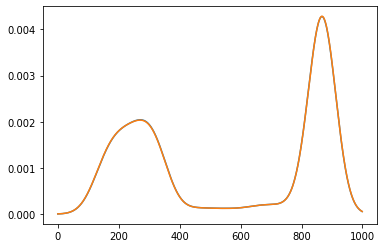

In [53]:

f,ax = plt.subplots()
ax.plot(rare_prior.ravel())
us_prior = rare_post.sum(axis=0)/(u.gaussian(xx[np.newaxis,:],.3,xx[:,np.newaxis])/Zspline(xx)[np.newaxis,:]).sum(axis=1)
ax.plot(us_prior/us_prior.sum())

In [54]:
print(rare_simdat.shape)

(100, 100, 1000)


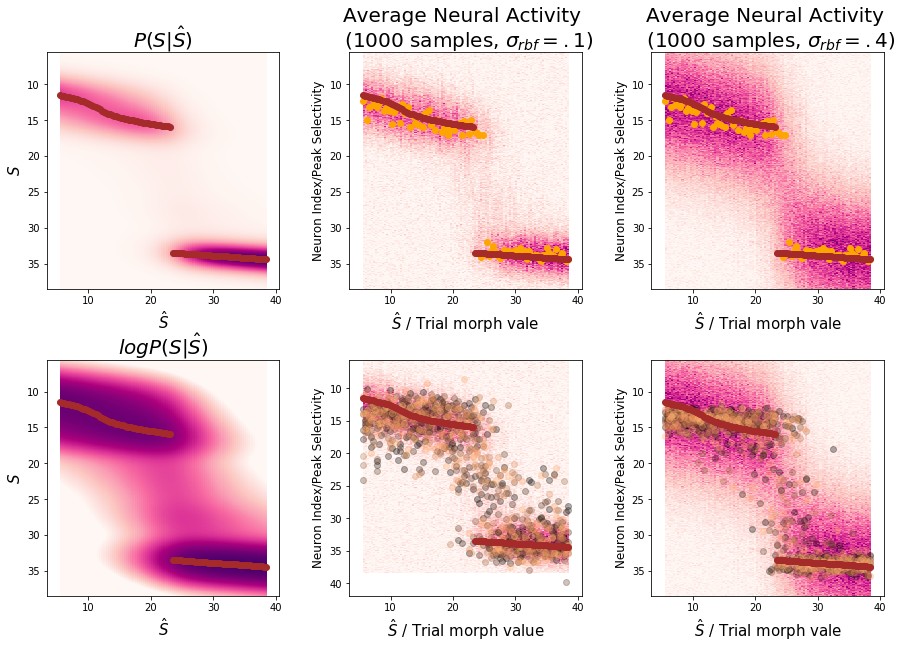

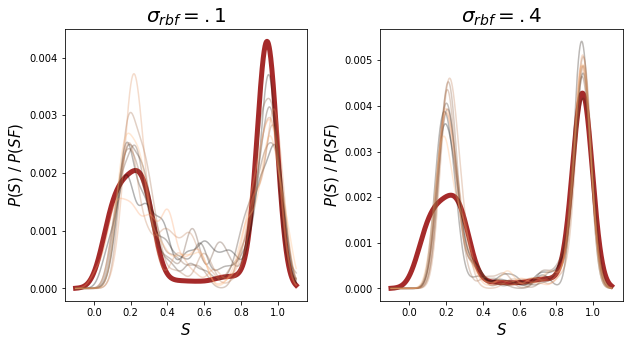

In [55]:
f,ax = plt.subplots(2,3,figsize=[15,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(rare_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(rare_post,20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[0,0].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)



ax[1,0].imshow(np.log(rare_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(rare_post),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[1,0].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[1,0].set_title("$log P(S|\hat{S})$",fontsize=20)

rare_simdat_mean = rare_simdat.mean(axis=0)
# print(x.shape,rare_simdat_mean.shape,np.argmax(rare_simdat_mean,axis=1).shape)
ax[0,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[0,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown',zorder=10)
ax[0,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_simdat_mean,axis=1)]),color='orange')
# # ax[0,1].scatter(_x,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
# ax[0,1].scatter(morphs,ut.wallmorphx(x[0,np.argmax(rare_simdat_mean,axis=1)]),color='orange')
ax[0,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,1].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,1].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[1,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown',zorder=10)
ax[1,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,1].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(rare_sf[j,:]),zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)

rare_simdat_wide_mean = rare_simdat.mean(axis=0)
ax[0,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[0,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown',zorder=10)
ax[0,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_simdat_wide_mean,axis=1)]),color='orange')
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[1,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(rare_post,axis=1)]),color='brown',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(rare_sf_wide[j,:]),zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
ax[1].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_rare_sf_bins = np.sum(u.gaussian(rare_sf[j:j+1,:],.05,xx[:,np.newaxis]),axis=1)/(u.gaussian(xx[np.newaxis,:],.3,xx[:,np.newaxis])/Zspline(xx)[np.newaxis,:]).sum(axis=1)
#     _j_rare_sf_bins = rare_simdat[j,:,:].sum(axis=1)
    ax[0].plot(xx,_j_rare_sf_bins/_j_rare_sf_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
#     _j_rare_sf_wide_bins = np.mean(u.gaussian(rare_sf_wide[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    _j_rare_sf_wide_bins = np.sum(u.gaussian(rare_sf_wide[j:j+1,:],.05,xx[:,np.newaxis]),axis=1)/(u.gaussian(xx[np.newaxis,:],.3,xx[:,np.newaxis])/Zspline(xx)[np.newaxis,:]).sum(axis=1)
    ax[1].plot(xx,_j_rare_sf_wide_bins/_j_rare_sf_wide_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)

f.subplots_adjust(wspace=.3)
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.png",format='png')

In [29]:
freq_post,xx,Z = ssm.calculate_posterior(freq_prior,_x,xx_lims = (-.1,1.1),calcZ=True)
freq_simdat,freq_sm, freq_sf = ssm.simmat_distribution(_x,freq_prior,n_neurons=1000,nperms=100,rbf_sigma=.1,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])
freq_simdat_wide,freq_sm, freq_sf_wide = ssm.simmat_distribution(_x,freq_prior,n_neurons=1000,nperms=100,rbf_sigma=.4,alpha=1.5,beta=0.25,xx_lims=[-.3,1.3])


Zspline = spline(_x,Z)
map_estimate = xx[np.argmax(freq_post,axis=1)]
for p in range(100):
    linmodel = hreg().fit(freq_sf[p:p+1,:].T,map_estimate)
    freq_sf[p,:] = linmodel.predict(freq_sf[p:p+1,:].T)
    linmodel = hreg().fit(freq_sf_wide[p:p+1,:].T,map_estimate)
    freq_sf_wide[p,:] = linmodel.predict(freq_sf_wide[p:p+1,:].T)
    
    
    

0
0


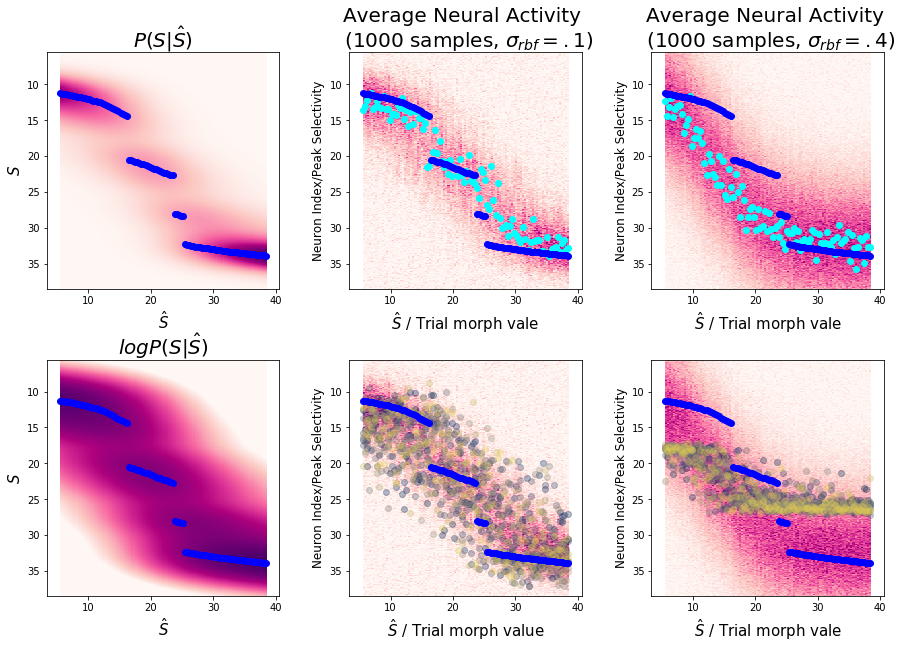

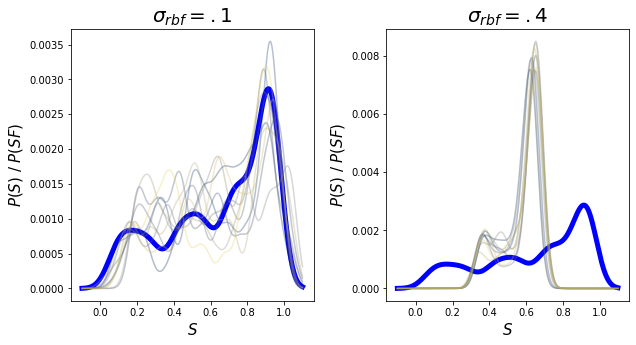

In [35]:
f,ax = plt.subplots(2,3,figsize=[15,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(freq_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(freq_post,20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[0,0].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)




ax[1,0].imshow(np.log(freq_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(freq_post),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[1,0].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[1,0].set_title("$log P(S|\hat{S})$",fontsize=20)



freq_simdat_mean=freq_simdat.mean(axis=0)
ax[0,1].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[0,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue',zorder=10)
ax[0,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_simdat_mean,axis=1)]),color='cyan')
ax[0,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,1].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,1].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,1].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)])
ax[1,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue',zorder=10)
ax[1,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,1].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,1].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(freq_sf[j,:]),zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)

freq_simdat_wide_mean=freq_simdat_wide.mean(axis=0)
ax[0,2].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent  = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[0,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue',zorder=10)
ax[0,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_simdat_wide_mean,axis=1)]),color='cyan')
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,2].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [ut.inv_wallmorphx(-.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(1.1),ut.inv_wallmorphx(-.1)],zorder=0)
ax[1,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(xx[np.argmax(freq_post,axis=1)]),color='blue',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,2].scatter(ut.inv_wallmorphx(_x),ut.inv_wallmorphx(freq_sf_wide[j,:]),zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
ax[1].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_freq_sf_bins = np.mean(u.gaussian(freq_sf[j:j+1,:],.05,xx[:,np.newaxis]),axis=1)/(u.gaussian(xx[np.newaxis,:],.3,xx[:,np.newaxis])/Zspline(xx)[np.newaxis,:]).sum(axis=1)
    ax[0].plot(xx,_j_freq_sf_bins/_j_freq_sf_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    _j_freq_sf_wide_bins = np.mean(u.gaussian(freq_sf_wide[j:j+1,:],.05,xx[:,np.newaxis]),axis=1)/(u.gaussian(xx[np.newaxis,:],.3,xx[:,np.newaxis])/Zspline(xx)[np.newaxis,:]).sum(axis=1)
    ax[1].plot(xx,_j_freq_sf_wide_bins/_j_freq_sf_wide_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)



f.subplots_adjust(wspace=.3)

f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.png",format='png')

In [22]:
def single_session_kldiv(_wm,_yh):
    x=np.linspace(-.3,1.3,num=1000)
    wmsm = u.gaussian(_wm[:,np.newaxis,np.newaxis],.1,x[np.newaxis,:,np.newaxis])
    yhsm = u.gaussian(_yh[:,np.newaxis,np.newaxis],.1,x[np.newaxis,np.newaxis,:])
    H = np.sum(wmsm*yhsm,axis=0)
    Z=H.sum(axis=1)
    H/=H.sum(axis=1,keepdims=True)
    xmask = (x>=-.1) & (x<=1.1)
    rare_kl,freq_kl = [],[]
    for row in range(H.shape[1]):
        if (x[row]>=.1) and (x[row]<=1.1):
            rare_kl.append(sp.stats.entropy(rare_post[row,:],H[row,:],base=2))
            freq_kl.append(sp.stats.entropy(freq_post[row,:],H[row,:],base=2))
    return H[xmask,:].T, np.array(rare_kl).mean()-np.array(freq_kl).mean()

In [23]:
df_mouse = df[df["MouseName"]=='4343706']
for sess_ind in range(1): # ,df_mouse.shape[0]):
    sess = df_mouse.iloc[sess_ind]
    trial_info,S_trial_mat, SM, SF, SIMDATA, SIMDATA_SM, SIMDATA_SF= ssm.run_simmat_distributions(sess,rare_prior,freq_prior,nperms=1000,n_samps=1,rbf_sigma=.4,alpha = 1.,
                            beta = .25,xx_lims = (-.1,1.1),basedir = "D:\\Suite2P_Data\\")
    print(SIMDATA_SF['rare'].shape)
    yhat = (SF- np.median(SF[trial_info['morphs']==0]))/(np.median(SF[trial_info['morphs']==1])-np.median(SF[trial_info['morphs']==0]))*(1.073-.094) +.094 
    yhat = np.clip(yhat,-.3,1.3)
    morphs = trial_info['morphs']+trial_info['wallJitter']
    H,dkl = single_session_kldiv(ut.wallmorphx(morphs),yhat)
    
    print
    
#     ssm.simulate_session_plot_results(sess,rare_prior,freq_prior)

rare
0
100
200
300
400
500
600
700
800
900
freq
0
100
200
300
400
500
600
700
800
900
(1000, 65)


IndexError: index 250 is out of bounds for axis 0 with size 100

In [24]:
rare_post.shape

(100, 1000)

In [ ]:
yhat = (sf- np.median(sf[trial_info['morphs']==0]))/(np.median(sf[trial_info['morphs']==1])-np.median(sf[trial_info['morphs']==0]))*(1.073-.094) +.094 
        yhat = np.clip(yhat,-.3,1.3)
        H,dkl = single_session_kldiv(ut.wallmorphx(morphs),yhat)

In [15]:
for (mouse, first_ind)  in zip(['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1'],[5,5,5,3,5,1,4,4,4,4,4,4]):
    df_mouse = df[df["MouseName"]==mouse]
    
    for sess_ind in range(first_ind,df_mouse.shape[0]):
        sess = df_mouse.iloc[sess_ind]
        ssm.simulate_session_plot_results(sess)


TypeError: simulate_session_plot_results() missing 2 required positional arguments: 'rare_prior' and 'freq_prior'

In [3]:
llr_dict = {}
for (mouse, first_ind)  in zip(['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1'],[5,5,5,3,5,1,4,4,4,4,4,4]):
    df_mouse = df[df["MouseName"]==mouse]
    llr_dict[mouse]=[]
    for sess_ind in range(first_ind,df_mouse.shape[0]):
        sess = df_mouse.iloc[sess_ind]
        sesspath = os.path.join("D:\\Morph_Results\\figures\\TheoreticalSimMats","%s_%s_%d" % (mouse,sess["DateFolder"],sess["SessionNumber"]),"simresults.pkl")
        print(sesspath)
        with open(sesspath,'rb') as f:
            results = pickle.load(f)
#             print(results.keys())
        llr_dict[mouse].append(results['llr'])

D:\Morph_Results\figures\TheoreticalSimMats\4139265.3_19_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.3_21_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.3_22_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.3_23_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.3_24_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_17_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_18_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_19_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_20_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_21_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.4_22_02_2019_2\simresults.pkl
D:\Morph_Results\figures\TheoreticalSimMats\4139265.5_19_02_2019_2\simresults.pkl
D:\Morph_Results

In [1]:
f,ax = plt.subplots()
print(mouse)
print(llr_dict['4343706'])
rare_mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706']
for m,mouse in enumerate(rare_mice):
    ax.scatter(m+.4*(np.random.rand(len(llr_dict[mouse]))-.5),-llr_dict[mouse],color = plt.cm.copper(np.float(m)/len(rare_mice)))
freq_mice=['4222153.1','4222153.2','4222153.3','4222174.1','4222154.1','4343702.1']
for m, mouse in enumerate(freq_mice):
    ax.scatter(len(rare_mice)+m+.4*(np.random.rand(len(llr_dict[mouse]))-.5),llr_dict[mouse],color = plt.cm.cividis(np.float(m)/len(rare_mice)))
# ax.plot([-.1,10.1],[0,0],color='red')
ax.fill_between([-.3,10.3],[1,1],[-1,-1],color='black',alpha=.3)
ax.set_xlim([-.3,10.3])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,11))
ax.set_xticklabels(['R1','R2','R3','R4','R5','R6','F1','F2','F3','F4','F5','F6'])
ax.set_ylabel("LLR")
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\LLR_by_session.png",format='png')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\LLR_by_session.pdf",format='pdf')

NameError: name 'plt' is not defined

In [40]:
10**1

10